In [10]:
import numpy as np
import gym
from gym import spaces
import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [4]:
!pip install ipynb

In [11]:
from ipynb.fs.full.epienv import EpistasisEnv

In [12]:
env = EpistasisEnv()
env.reset()

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 2, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 2, 0, 0]])

In [8]:
# env.action_space.sample()
snp_ids=[0, 3, 4, 5, 8, 11, 12, 15, 16, 19, 21, 22, 27, 28, 29, 32, 34, 35, 37, 39, 40, 42, 43, 45, 47, 48, 50, 52, 53, 54, 57, 60, 61, 64, 68, 74, 76, 78, 79, 84, 86, 87, 89, 92, 96, 99]
env._count_reward(snp_ids)

1.9990009990009991

In [9]:
env._count_reward([0,1])

0.9785879789030052

In [10]:
len(env.obs_phenotypes)

600

In [11]:
env.N_SNPS

100

env.disease_snps

## Смотрим как выглядят rewards для всех возможных пар снипов

0 10 20 30 40 60 70 80 90 

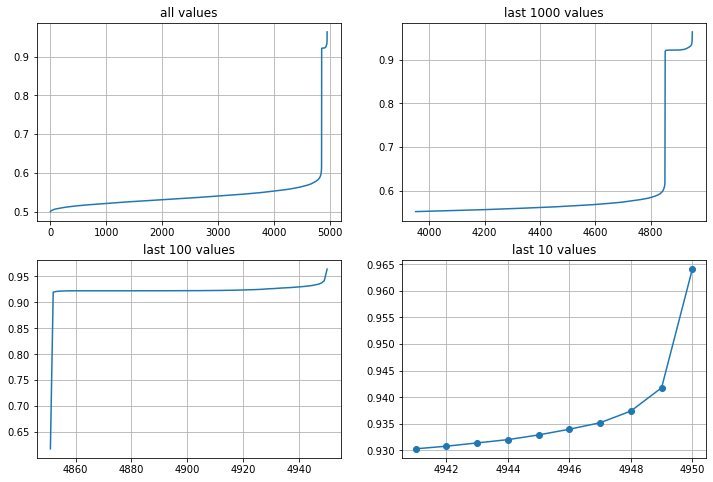

In [10]:
env = EpistasisEnv()
N_rewards = 4950
N_runs = 100
sorted_rewards_list = np.zeros(N_rewards)
for i in range(N_runs):
    if i % 10 == 0:
        print(i, end=' ')
    obs = env.reset()
    rewards = {}
    for i in range(env.N_SNPS):
        for j in range(env.N_SNPS):
            if (i == j):
                continue
            new = env._count_reward([i,j])
            rewards[frozenset((i,j))] = new
    sorted_rewards_list += np.array(sorted(rewards.values()))
    
sorted_rewards_list /=  N_runs


figure, axis = plt.subplots(2, 2, figsize=(12,8))
N = N_rewards

axis[0, 0].plot(range(1, N+1), sorted_rewards_list)
axis[0, 0].set_title("all values")
axis[0, 0].grid(True)

last=1000
axis[0, 1].plot(range(N-last+1, N+1), list(sorted_rewards_list)[-last:])
axis[0, 1].set_title(f"last {last} values")
axis[0, 1].grid(True)

last=100
axis[1, 0].plot(range(N-last+1, N+1), list(sorted_rewards_list)[-last:])
axis[1, 0].set_title(f"last {last} values")
axis[1, 0].grid(True)

last=10
axis[1, 1].plot(range(N-last+1, N+1), list(sorted_rewards_list)[-last:], 'o-')
axis[1, 1].set_title(f"last {last} values")
axis[1, 1].grid(True)
  
# Combine all the operations and display
plt.savefig(f"fig_average_{N_runs}.pdf")
plt.show()

In [31]:
rewards = {}
vl = 0
minval = 2
for i in range(100):
    for j in range(100):
        if (i == j):
            continue
        try:
            new = env._count_reward([i,j])
#             print(i,j)
            rewards[frozenset((i,j))] = new
            if new < 0:
                print("new<0", new, i, j)
            if new > vl:
                vl = new
                ij = (i, j)
            if new < minval:
                minval = new
                ijmin = (i,j)
        except ZeroDivisionError:
              print("ZeroDivisionError", i, j)
print(vl, ij)
print(minval, ijmin)

delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
1.0047966247215971 (0, 1)
0.5 (23, 30)


In [32]:
len(rewards)

4950

In [33]:
sorted_rewards = {k: v for k, v in sorted(rewards.items(), key=lambda item: item[1])}

In [34]:
list(sorted_rewards.values())[-100:]

[0.617127687914761,
 0.974559703649596,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.977349718666

/home/tskhakharova/.conda/envs/gen_env/lib/python3.9/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


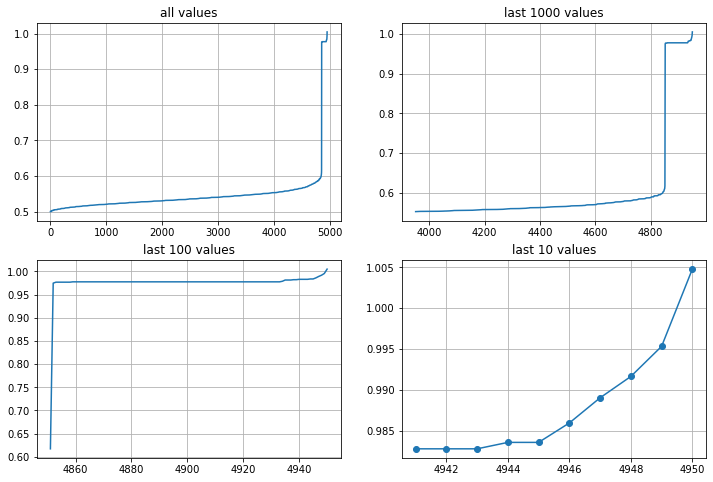

In [35]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(7,5))
# plt.plot(list(sorted_rewards.values())[-10:])
# plt.grid(True)

figure, axis = plt.subplots(2, 2, figsize=(12,8))
N = len(sorted_rewards)

axis[0, 0].plot(range(1, N+1), sorted_rewards.values())
axis[0, 0].set_title("all values")
axis[0, 0].grid(True)

last=1000
axis[0, 1].plot(range(N-last+1, N+1), list(sorted_rewards.values())[-last:])
axis[0, 1].set_title(f"last {last} values")
axis[0, 1].grid(True)

last=100
axis[1, 0].plot(range(N-last+1, N+1), list(sorted_rewards.values())[-last:])
axis[1, 0].set_title(f"last {last} values")
axis[1, 0].grid(True)

last=10
axis[1, 1].plot(range(N-last+1, N+1), list(sorted_rewards.values())[-last:], 'o-')
axis[1, 1].set_title(f"last {last} values")
axis[1, 1].grid(True)
  
# Combine all the operations and display
plt.savefig(f"fig_average_{N_runs}.pdf")
plt.show()


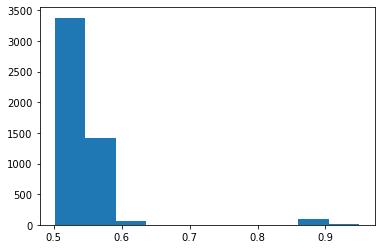

In [30]:
fig, ax = plt.subplots()


In [14]:
env._count_reward([0,1])

0.923156568820646

In [7]:
a = [1,1,1]
n = [2,2]
np.random.choice(np.concatenate([a,n]), 5, replace=False)

array([1, 2, 1, 2, 1])

## Эксперимент с 3 снипами

In [5]:
env = EpistasisEnv()
env.reset()
print(env._count_reward([0,1]))
print(env._count_reward([0,1,2]))
print(env._count_reward([0,1,2,3]))
print(env._count_reward([0,1,2,3,4]))
print(env._count_reward([0,1,2,3,4,5]))
print("----")
print(env._count_reward([2,1,]))
print(env._count_reward([1,2,3]))
print(env._count_reward([1,2,3,4]))
print(env._count_reward([1,2,3,4,5]))

0.8952808832982517
0.8947190996803183
0.9013741875043226
0.9033121193542831
0.9275336181037996
----
0.8530255697462015
0.8586757995882955
0.8599047831184818
0.8854873536009097


In [4]:
n = 1000
env = EpistasisEnv()
env.reset()
rewards = []
for i in range(n):
    snps = list(np.random.choice(100, size=3, replace=False))
    rewards.append((env._count_reward(snps), snps))

In [5]:
sorted(rewards, key=lambda x:x[0])

[(0.5104175239050992, [50, 66, 30]),
 (0.5104257824722767, [50, 72, 78]),
 (0.5122221527864573, [17, 96, 85]),
 (0.5122232589226283, [50, 38, 10]),
 (0.5122451957361999, [74, 99, 72]),
 (0.5123492206835041, [41, 0, 50]),
 (0.5141244590975689, [35, 75, 94]),
 (0.5141450212126595, [45, 74, 59]),
 (0.5142973502859329, [17, 50, 35]),
 (0.515913532790549, [61, 72, 85]),
 (0.5160458972597763, [33, 30, 17]),
 (0.5161643948580266, [33, 69, 90]),
 (0.5163017873089751, [50, 61, 41]),
 (0.5176216008611914, [74, 38, 94]),
 (0.517779391845731, [78, 74, 33]),
 (0.5178174810266387, [99, 64, 24]),
 (0.5179795978890798, [40, 65, 69]),
 (0.5182430854715177, [96, 99, 54]),
 (0.5188451023320154, [74, 23, 3]),
 (0.5197167828930082, [0, 99, 77]),
 (0.5197478857293244, [70, 36, 32]),
 (0.5199709710444539, [65, 64, 23]),
 (0.5202026447945485, [50, 86, 20]),
 (0.5204429156384778, [65, 6, 85]),
 (0.521634038251383, [82, 73, 53]),
 (0.5216489511296689, [73, 10, 71]),
 (0.5216852764883332, [17, 86, 80]),
 (0.5217

In [3]:
env = EpistasisEnv()
env.reset()
print(env._count_reward([1, 56, 55]))
print(env._count_reward([1, 0, 55]))

0.9089108881528849
0.9260124259757805


In [10]:
env._count_reward([1, 0, 9, 10, 11, 78])

0.9706403703257495